In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import corner
import dill
import sys, os

In [2]:
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz

In [3]:
from jkepler.kepler import *
from jkepler.rv import rv_unit_amplitude as getrv

In [4]:
#import seaborn as sns
#sns.set(style='ticks', font_scale=1.6, font='times')
#sns.set_palette('colorblind')
#from matplotlib import rc
#rc('text', usetex=True)

In [5]:
%matplotlib inline

## load data

In [6]:
from jkepler.tests.read_testdata import read_testdata_rv
t, y, yerr, tepoch = read_testdata_rv()
print ('# number of data points:', len(t), '\n# epoch (BJD):', tepoch)

# number of data points: 86 
# epoch (BJD): 2454065.57926


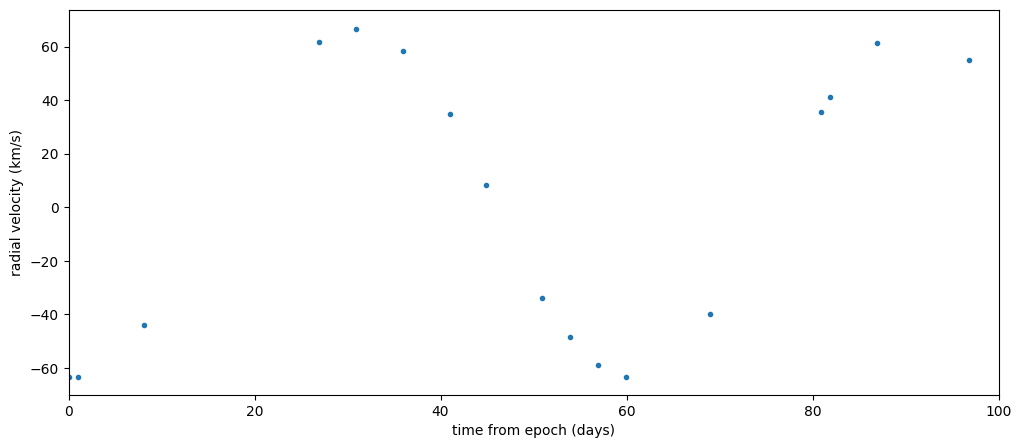

In [7]:
# where's the inferior conjunction?
plt.figure(figsize=(12,5))
plt.xlim(0, 100)
plt.xlabel("time from epoch (days)")
plt.ylabel("radial velocity (km/s)")
plt.plot(t, y, '.')

## run HMC

In [ ]:
# initial guess for period and time of inferior conjunction
period_guess = 59.94
t0_guess = (25, 75)

In [ ]:
def model(t, y, yerr, emax=0.95):
    logK = numpyro.sample("logK", dist.Uniform(-5, 5))
    K = numpyro.deterministic("K", 10**logK)

    ecc = numpyro.sample("ecc", dist.Uniform(0, emax))
    cosw = numpyro.sample("cosw", dist.Normal())
    sinw = numpyro.sample("sinw", dist.Normal())
    omega = numpyro.deterministic("omega", jnp.arctan2(sinw, cosw))

    period = numpyro.sample("period", dist.Uniform(period_guess*0.99, period_guess*1.01))
    t0 = numpyro.sample("t0", dist.Uniform(t0_guess[0], t0_guess[1]))
    tau = numpyro.deterministic("tau", t0_to_tau(t0, period, ecc, omega))
    
    rv_no_offset = numpyro.deterministic("rv_no_offset", K * getrv(t, period, ecc, omega, tau))
    gamma = numpyro.sample("gamma", dist.Uniform(low=-30, high=30))
    rvmodel = numpyro.deterministic("rvmodel", rv_no_offset + gamma)
    
    res = y - rvmodel
    lnrvjitter = numpyro.sample("lnrvjitter", dist.Uniform(low=-5, high=0))
    rvjitter = numpyro.deterministic("rvjitter", jnp.exp(lnrvjitter))
    sigma2 = rvjitter**2 + yerr**2
    loglikelihood = -0.5 * jnp.sum(res**2/sigma2 + jnp.log(sigma2))
    numpyro.factor("loglike", loglikelihood)

In [ ]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.95)

In [ ]:
n_wm = 2000
n_sample = 2000

In [ ]:
mcmc = numpyro.infer.MCMC(kernel, num_warmup=n_wm, num_samples=n_sample)

In [ ]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, t, y, yerr, extra_fields=('potential_energy',))

sample: 100%|████████████████████████████████████████| 4000/4000 [00:30<00:00, 131.49it/s, 63 steps of size 4.70e-02. acc. prob=0.97]


In [ ]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
        cosw      0.07      0.10      0.05     -0.08      0.22    734.27      1.00
         ecc      0.02      0.00      0.02      0.01      0.02   1358.87      1.00
       gamma      1.83      0.05      1.83      1.75      1.92   1564.98      1.00
  lnrvjitter     -0.90      0.10     -0.90     -1.07     -0.75   1254.09      1.00
        logK      1.82      0.00      1.82      1.82      1.82   2065.56      1.00
      period     59.94      0.00     59.94     59.93     59.94   1327.56      1.00
        sinw      1.23      0.64      1.14      0.19      2.15    493.70      1.00
          t0     45.69      0.03     45.70     45.65     45.74   1137.99      1.00

Number of divergences: 23


In [ ]:
samples = mcmc.get_samples()

## corner & trace plots

In [ ]:
keys = ["tau", "period", "K", "ecc", "omega", "gamma", "rvjitter"]
labels = keys

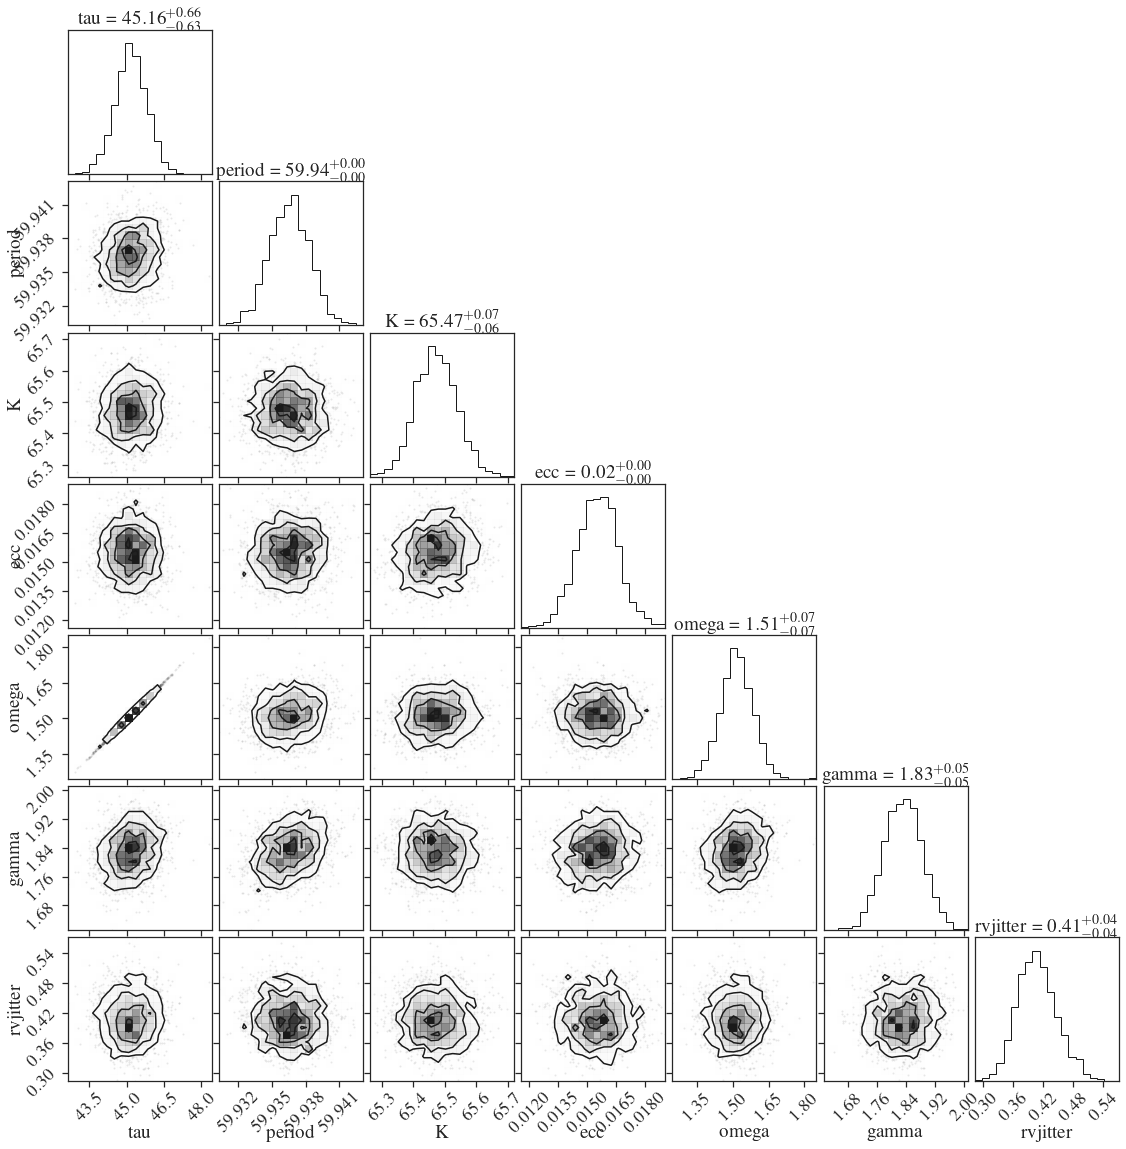

In [ ]:
hyper = pd.DataFrame(data=dict(zip(keys, [samples[k] for k in keys])))
fig = corner.corner(hyper, labels=labels, show_titles="%.2f")

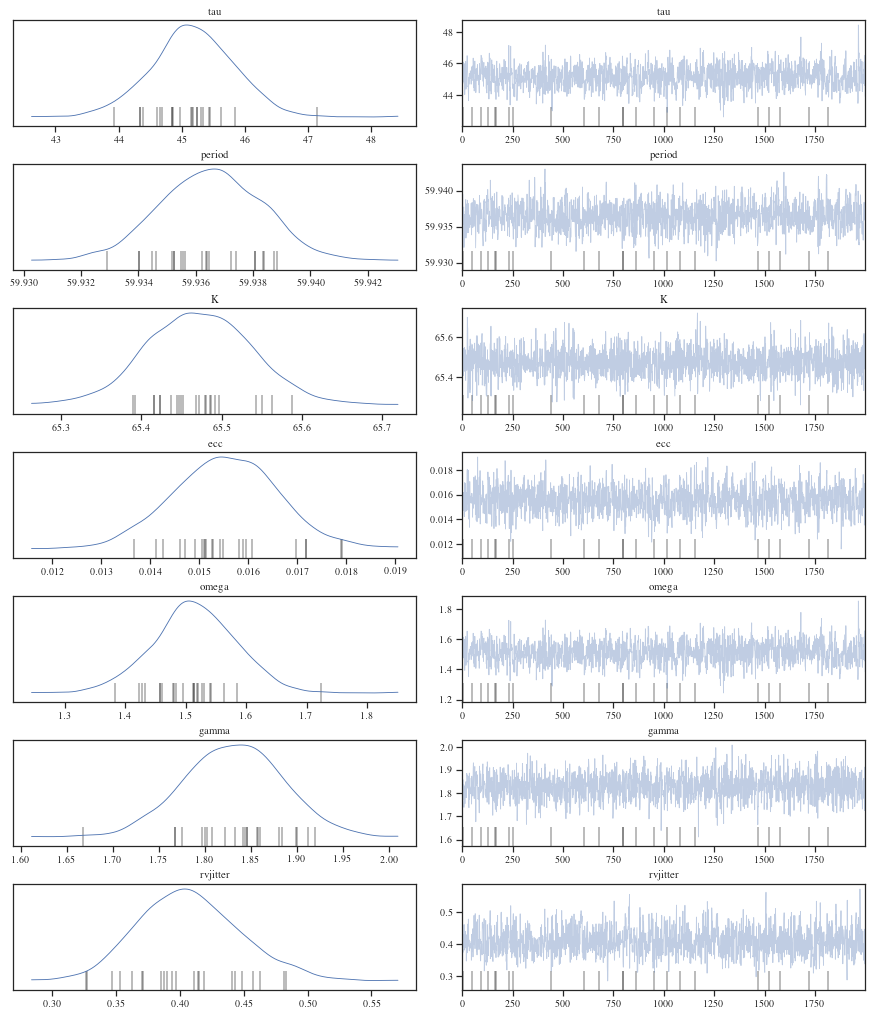

In [ ]:
fig = arviz.plot_trace(mcmc, var_names=keys)

## model vs data

In [ ]:
predictive = Predictive(model, samples, return_sites=["rvmodel", "rvmodel_base"])

In [ ]:
preds = predictive(rng_key, t=t, y=y, yerr=yerr)

In [ ]:
t2 = np.linspace(t[0], t[-1], 1000)
preds2 = predictive(rng_key, t=t2, y=t2*0, yerr=t2*0)

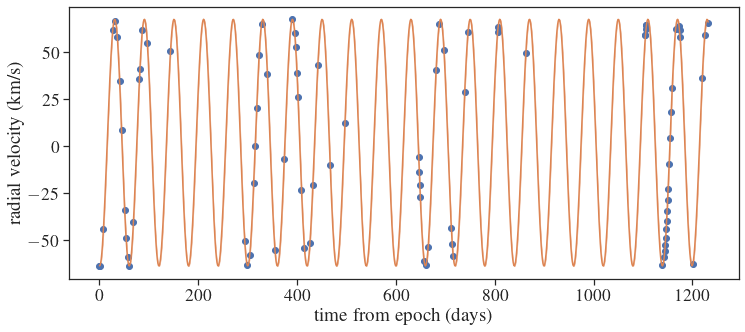

In [ ]:
mean2, std2 = np.mean(preds2['rvmodel'], axis=0), np.std(preds2['rvmodel'], axis=0)
mean1, std1 = np.mean(preds['rvmodel'], axis=0), np.std(preds['rvmodel'], axis=0)
plt.figure(figsize=(12,5))
plt.ylabel("radial velocity (km/s)")
plt.xlabel("time from epoch (days)")
plt.plot(t, y, 'o')
plt.plot(t2, mean2, '-', label='mean model', color='C1')
plt.fill_between(t2, mean2-std2, mean2+std2, color='C1', alpha=0.4);

In [ ]:
def phasefold(time, flux, t0, period):
    t_fold = (time - t0  + 0.5 * period) % period - 0.5 * period
    index = np.argsort(t_fold)
    return t_fold[index], flux[index]

In [ ]:
t0mean, pmean = jnp.mean(samples['t0']), jnp.mean(samples['period'])
tp, yp = phasefold(t, y, t0mean, pmean)
tp1, yp1 = phasefold(t, mean1, t0mean, pmean)
tp2, yp2 = phasefold(t2, mean2, t0mean, pmean)

/Users/k_masuda/.pyenv/versions/anaconda3-5.3.1/envs/py38/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3237: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


### in fact the data includes a non-Keplerian component...

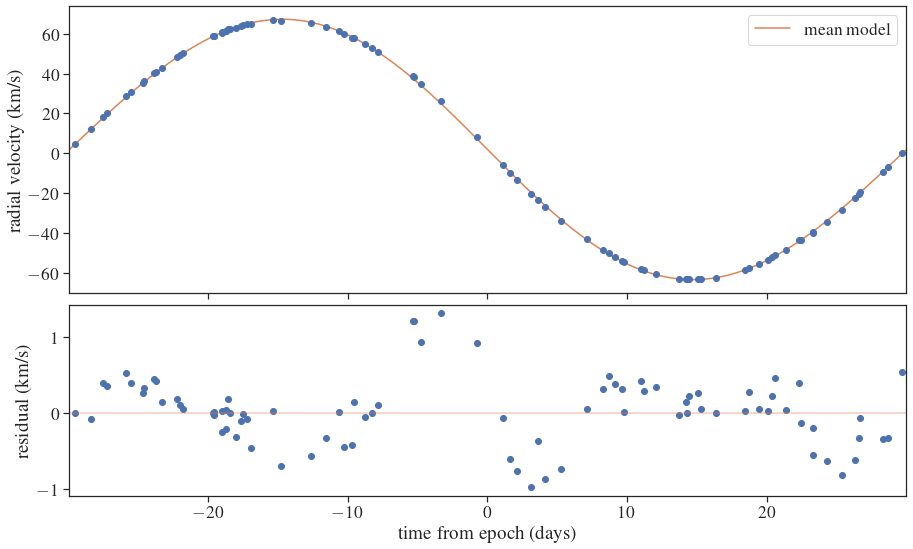

In [ ]:
fig, ax = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 2], "hspace": 0.05}, sharex=True, figsize=(15,9))
ax[0].set_xlim(-0.5*pmean, 0.5*pmean)
ax[0].plot(tp, yp, 'o')
ax[0].plot(tp2, yp2, '-', zorder=-1000, label='mean model')
ax[0].legend(loc='best')
ax[1].plot(tp, yp-yp1, 'o')
ax[1].axhline(y=0, color='C1', alpha=0.4)
ax[0].set_ylabel("radial velocity (km/s)")
ax[1].set_ylabel("residual (km/s)")
ax[1].set_xlabel("time from epoch (days)");